# Linear Regression and k-NN classification algorithms

In [1]:
# loading all needed libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


### 1. Moore's Law

In [2]:
# a script to ignore possible warnings for cleaner code reading
import warnings
warnings.simplefilter('ignore') 

In [3]:
# import benchmark csv file 
benchmark = pd.read_csv('benchmarks.csv')
benchmark.head()

,testID,benchName,base,peak
0,cpu95-19990104-03254,101.tomcatv,19.40,27.1
1,cpu95-19990104-03254,102.swim,27.20,34.8
2,cpu95-19990104-03254,103.su2cor,10.10,9.98
3,cpu95-19990104-03254,104.hydro2d,8.58,8.61
4,cpu95-19990104-03254,107.mgrid,8.94,9.44


In [4]:
benchmark.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136995 entries, 0 to 136994
Data columns (total 4 columns):
testID       136995 non-null object
benchName    136995 non-null object
base         136995 non-null float64
peak         131575 non-null object
dtypes: float64(1), object(3)
memory usage: 4.2+ MB


### Some observations: 
1. Our current dataset contains some non-null elements within peak column as we can see from the info of benchmark dataset. However, the base column which concerns us for the further model is in tact with all elements. 

2.  The dates contained as part of the testID don't tell us about when the hardware was actually designed, so the test could have been run at a much later date using older hardware. We therefore need the date indicating when the hardware was first available (hwAvail) from the summaries file to really test Moore's Law. 
Hence, we need to merge both datasets on testID and then use benchName with hwAvail to extract dates.  

In [5]:
# observe all benchmark names to pick one 
pd.unique(benchmark.benchName)

array(['101.tomcatv', '102.swim', '103.su2cor', '104.hydro2d',
       '107.mgrid', '110.applu', '125.turb3d', '141.apsi', '145.fpppp',
       '146.wave5', '099.go', '124.m88ksim', '126.gcc', '129.compress',
       '130.li', '132.ijpeg', '134.perl', '147.vortex', '168.wupwise',
       '171.swim', '172.mgrid', '173.applu', '177.mesa', '178.galgel',
       '179.art', '183.equake', '187.facerec', '188.ammp', '189.lucas',
       '191.fma3d', '200.sixtrack', '301.apsi', '164.gzip', '175.vpr',
       '176.gcc', '181.mcf', '186.crafty', '197.parser', '252.eon',
       '253.perlbmk', '254.gap', '255.vortex', '256.bzip2', '300.twolf',
       '400.perlbench', '401.bzip2', '403.gcc', '429.mcf', '445.gobmk',
       '456.hmmer', '458.sjeng', '462.libquantum', '464.h264ref',
       '471.omnetpp', '473.astar', '483.xalancbmk', '410.bwaves',
       '416.gamess', '433.milc', '434.zeusmp', '435.gromacs',
       '436.cactusADM', '437.leslie3d', '444.namd', '447.dealII',
       '450.soplex', '453.povray', 

### 1. Extract the date and base speed for a benchmark of your choice. 

#### a. Let's start by observing summaries dataset:

In [6]:
# import summaries csv file 
summaries = pd.read_csv('summaries.csv')
summaries.head()

,testID,tester,machine,cpu,mhz,hwAvail,os,compiler,autoParallel,benchType,base,peak
0,cpu95-19990104-03254,Dell,Precision WorkStation 610 (450MHz),450 MHz Pentium II XEON,450.0,Jan-1999,Microsoft Windows NT 4.0 sp3,Intel Fortran Compiler 2.4,No,CFP95,13.9,15.2
1,cpu95-19990104-03256,Dell,Precision WorkStation 610 (450MHz),450 MHz Pentium II XEON,450.0,Jan-1999,Microsoft Windows NT 4.0 sp3,"Intel C Compiler 2.4 for Windows NT, Microsoft...",No,CINT95,19.0,19.0
2,cpu95-19990118-03257,"Siemens, Germany",CELSIUS 2000,Pentium II Xeon Processor 450 MHz,450.0,Nov-1998,Windows NT V4.0 (Service Pack 3),Intel C Compiler Plug-In 2.4,No,CINT95,18.9,18.9
3,cpu95-19990118-03258,"Siemens, Germany",CELSIUS 2000,Pentium II Xeon Processor 450 MHz,450.0,Nov-1998,Windows NT V4.0 (Service Pack 4),Intel Fortran Compiler Plug-In 2.4,No,CFP95,13.5,15.0
4,cpu95-19990122-03268,"Sun, Palo Alto",Sun Enterprise 3500,400MHz UltraSPARC II,400.0,Dec-1998,Solaris 2.7,Sun C 5.0,No,CINT95,14.3,17.7


In [7]:
summaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 12 columns):
testID          10155 non-null object
tester          10155 non-null object
machine         8982 non-null object
cpu             10155 non-null object
mhz             10155 non-null float64
hwAvail         10155 non-null object
os              10155 non-null object
compiler        10155 non-null object
autoParallel    10155 non-null object
benchType       10155 non-null object
base            10155 non-null float64
peak            10155 non-null object
dtypes: float64(2), object(10)
memory usage: 952.1+ KB


#### b. Extract a sample date from the benchmark hwAvail:

In [8]:
date1 = datetime.strptime(summaries['hwAvail'][0], '%b-%Y')
print(date1)

1999-01-01 00:00:00


#### c. Extract date column of harwdare availability from summaries table based on testID.

In [9]:
summaries['hwAvail_benchmark'] = summaries['hwAvail'].apply(lambda x: datetime.strptime(x,'%b-%Y'))
summaries_date_extracted = summaries[['testID', 'hwAvail_benchmark']]
summaries_date_extracted.head()


,testID,hwAvail_benchmark
0,cpu95-19990104-03254,1999-01-01
1,cpu95-19990104-03256,1999-01-01
2,cpu95-19990118-03257,1998-11-01
3,cpu95-19990118-03258,1998-11-01
4,cpu95-19990122-03268,1998-12-01


#### d. Left merge the extracted hwAvail_bnchmark date data with the benchmark table on testID key. 
We left merge as we want to keep every row from the left dataframe, benchmark, while adding the nw row from the righ table matching on the testID. 

In [10]:
date_benchmark = pd.merge(left=benchmark, right=summaries_date_extracted, how='left', left_on='testID', right_on='testID')
date_benchmark.head()


,testID,benchName,base,peak,hwAvail_benchmark
0,cpu95-19990104-03254,101.tomcatv,19.40,27.1,1999-01-01
1,cpu95-19990104-03254,102.swim,27.20,34.8,1999-01-01
2,cpu95-19990104-03254,103.su2cor,10.10,9.98,1999-01-01
3,cpu95-19990104-03254,104.hydro2d,8.58,8.61,1999-01-01
4,cpu95-19990104-03254,107.mgrid,8.94,9.44,1999-01-01


#### e. Convert the date from hwAvail_benchamrk into days for easy comparision. 

In [11]:
# picking a start point for comparative conversion 
initial_date = date_benchmark['hwAvail_benchmark'].min()
# creating a nw column to host the delta dates (day based)
date_benchmark['date_delta'] = date_benchmark['hwAvail_benchmark'].apply(lambda x:(x - initial_date).total_seconds() / 3600*24)


#### f. Selecting a benchmark name from the list of benchmark names observed earlier. 

In [12]:
date_benchmark = date_benchmark[date_benchmark['benchName']=='187.facerec']
date_benchmark.head()

,testID,benchName,base,peak,hwAvail_benchmark,date_delta
9958,cpu2000-19991130-00002,187.facerec,129.0,NaN,1999-05-01,1718208.0
9984,cpu2000-19991130-00004,187.facerec,200.0,NaN,1996-10-01,1175616.0
10010,cpu2000-19991130-00006,187.facerec,677.0,804,2000-02-01,1877184.0
10036,cpu2000-19991130-00008,187.facerec,178.0,NaN,1997-05-01,1297728.0
10062,cpu2000-19991130-00010,187.facerec,456.0,544,1998-12-01,1631232.0


### 2. Plot the data in a semi-log plot.



We transform the dependent variable, base, to log base while remaining the indepedent varible, time, in the original metric. 

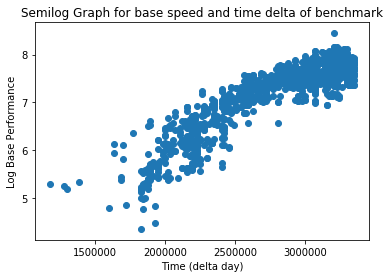

In [13]:
x_time = date_benchmark[['date_delta']]
y_baseLog = np.log(date_benchmark['base'].values)
plt.scatter(x_time, y_baseLog)
plt.xlabel('Time (delta day)')
plt.ylabel('Log Base Performance')
plt.title('Semilog Graph for base speed and time delta of benchmark')

plt.show()

### 3. Now train a linear model to fit your plot.


The plot has shown that log base performance has a linear relationship with the time. hence, we will be fitting our date into a linear regression. 

In [14]:
# splitting data into test and train sets

X_train, X_test, y_train, y_test = train_test_split(x_time, y_baseLog, test_size=0.2, random_state=1)

model = LinearRegression()
# fitting the training data
model.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
# predicting based on the test data
y_pred = model.predict(X_test)

#### Obeserving the performance stats on our model. 

In [16]:
# The coefficient
print('Coefficients: \n', model.coef_)
# The intercept
print('Intercept: \n', model.intercept_)
# The mean squared error
print('Mean squared error: %.2f' % MSE(y_test, y_pred))
# The median avarag error 
print("MAE: %.2f" % MAE(y_test, y_pred))
# R-squared: 
print('R-squared: %.2f' % R2(y_test, y_pred), ' showing that 81% of the variance in log based performance data can be explained by the dates.')



Coefficients: 
 [1.36642131e-06]
Intercept: 
 3.389017269286665
Mean squared error: 0.09
MAE: 0.24
R-squared: 0.81  showing that 81% of the variance in log based performance data can be explained by the dates.


##### We can now also check how well is our model at predicting the speed given time by comparing actual results to predicted.


Text(0.5, 1.0, 'Predcited log base performnce vs real log base performance')

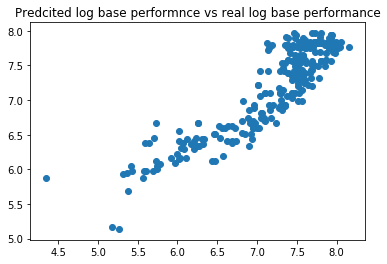

In [17]:
plt.scatter(y_test, y_pred)
plt.title("Predcited log base performnce vs real log base performance")

Text(0.5, 1.0, 'Difference between the actual and predcited log base performance values ')

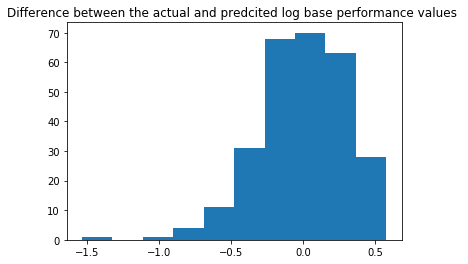

In [18]:
# looking at residuals
plt.hist(y_test - y_pred)
plt.title("Difference between the actual and predcited log base performance values ")



Previous two graphs show that our model is performing well for our data. The risiduals are almost normally distributed and the comparison graph shows that the predicted values are close to the real ones. However, both graphs also show that there are some outliers in our data and MSE of 0.09 shows that the model is almost perfect (close to 0).

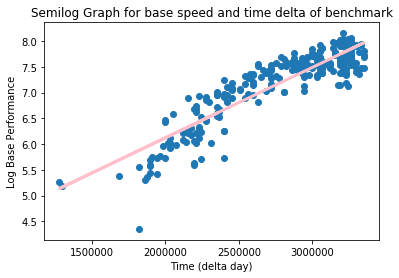

In [19]:
# Showcasing the results using plots
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color='pink', linewidth=3)
plt.xlabel('Time (delta day)')
plt.ylabel('Log Base Performance')
plt.title('Semilog Graph for base speed and time delta of benchmark')
plt.show()

Text(0.5, 1, 'Semilog Graph for base speed and time delta of benchmark')

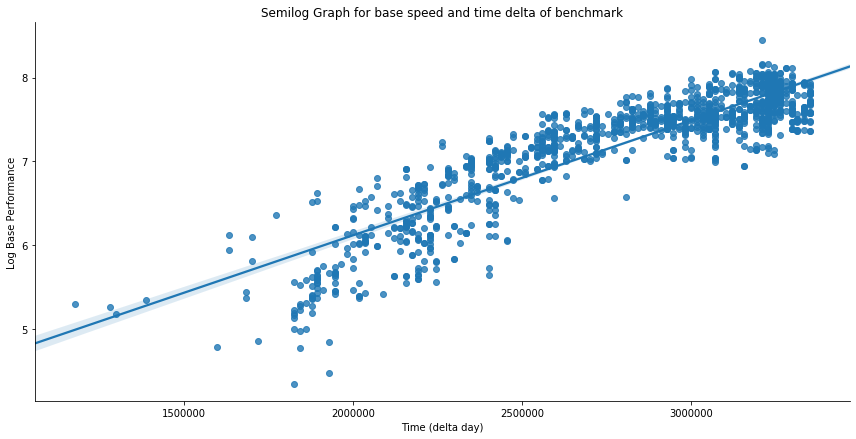

In [20]:
# using sns to plot a linear relationship between log base performance and time 
# with regression line on full set
date_benchmark['baseLog'] = np.log(date_benchmark.base)
ax = sns.lmplot(x='date_delta', y='baseLog', data=date_benchmark, height=6, aspect=2)
plt.xlabel('Time (delta day)')
plt.ylabel('Log Base Performance')
plt.title('Semilog Graph for base speed and time delta of benchmark')



### 3. How well is Moore's Law holding up?


The coefficient tells us that if all other variables remain constant, then every delta day increase in time will result in 1.36 times increase in the predicted variable, log base performance of cpu. 

Addionally, we can account for the fact that we transformed the dependent variable, base, into log base which affects the scale of the increase of the original metric of the base speed. Hence, to interpet the amount of change in the original metric of the output, we

1) exponentiate the coefficient of base to obtain exp(1.36082803)= 3.8994208027843 ~ 3.9;

2) subtract one from this number and multiply by 100 (How can I interpret log transformed variables in terms of percent change in linear regression?, n.d)


Thus, for every delta day increase in time, the base speed of the cpu increases by 290 percent.

Our model has R-squared of 0.81 which shows that around 81% of the variance in the log base performnce is explained by the dates. This is also supported by the regression model predcitions graphs showing that model is performing well (MSE = 0.09) but there are still some values not captured by the model. 

Moore's law shows that the number of transistors in a dense integrated circuit (IC) doubles about every two years based on Wikipedia. 

Since we do have a model explaining 81% variance in the change and for every delta day increase in time, the base speed of the cpu increases by 290 percent (in otherwords, exponentially), Moore's Law is holding up as it refers to an observation that the power of computers will increase exponentially.



# 2. MNIST Digits

No machine learning course would be complete without using the MNIST dataset. This dataset was a hugely influential dataset of handwriting digits (0-9).

### 1. Using scikit-learn, load the MNIST digits (see here).



In [21]:
# loading MNIST digits data file
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.data.shape)

(1797, 64)


### 2. Plot some of the examples.



<Figure size 432x288 with 0 Axes>

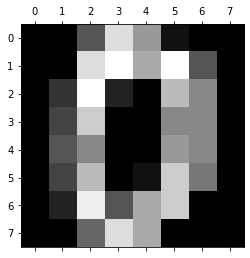

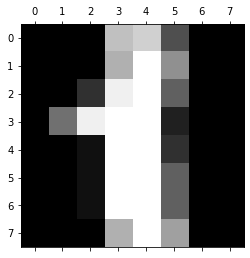

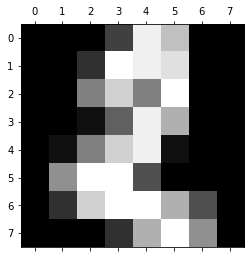

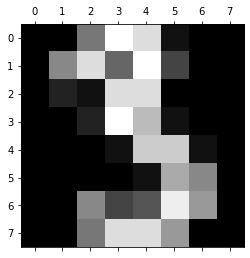

In [22]:
# showcasing examples 
plt.gray() 
plt.matshow(digits.images[0])
plt.matshow(digits.images[1]) 
plt.matshow(digits.images[2]) 
plt.matshow(digits.images[3]) 
plt.show() 

### 3. Choose two digit classes (e.g. 7s and 3s), and train a k-nearest neighbor classifier.



In [23]:
# Splitting the dataset into inputs and targets
X = digits.data
y = digits.target


X = X[np.logical_or(y == 3, y == 7)]
y = y[np.logical_or(y == 3, y == 7)]
# verify selection
np.unique(y)

array([3, 7])

In [24]:
# Splitting data into test and train sets
# Assigning 20% of data as testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))



(array([3, 7]), array([144, 145]))
(array([3, 7]), array([39, 34]))


In [25]:
# buidling a k-NN model
knn = KNeighborsClassifier()

#### Hypertuning to find the optimal parameters for our model to improve accuracy

We are using here hypertuning with cross-validation of cv = 5 in order to chose the most optimal parameters to minimize the error rate for our model. Usage of cross-validation will also help to mitigate overfitting of our model. 

In [26]:
# creating a dictionary by specifing a range of values for ‘n_neighbors’ in order to see which value works best for our model (k = majority of nearest points to base evaluation from)
k_n_param= {'n_neighbors': np.arange(3, 25, 2)}

# using  grid search and cross-validation to test all values for n_neighbors
hypertuned_knn = GridSearchCV(knn, k_n_param, cv = 5)

# fitting model to data
hypertuned_knn.fit(X_train, y_train)

# checking for the most optimal  of k-value and corresponding training accuracy score
print("The most optimal parameter of k is:", hypertuned_knn.best_params_)
print("The best accuracy score is:", hypertuned_knn.best_score_)


The most optimal parameter of k is: {'n_neighbors': 3}
The best accuracy score is: 0.9965397923875432


### 4. Report your error rates on a held out part of the data.



In [27]:
# using the test dataset to predict and calculate the error rate
predictions = hypertuned_knn.predict(X_test)
model_accuracy = metrics.accuracy_score(y_test, predictions)
# finding accuracy for holdout method (train-test-split method)
print(' The error rate with the most optimal parameter, k=3, is:', round(1-hypertuned_knn.best_score_, 6))
print(' The error rate with the holdout method is:', round(1-model_accuracy, 6))


 The error rate with the most optimal parameter, k=3, is: 0.00346
 The error rate with the holdout method is: 0.013699


The error rate shows that the model has a great accuracy when predicting 3 or 7. 

### 5. Test your model on the full dataset (available from http://yann.lecun.com/exdb/mnist/)

In [28]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [29]:
#reshaping the 3d to 2d set 
nsamples, nx, ny = x_train.shape
d2_x_train = x_train.reshape((nsamples,nx*ny))

nsamples_t, nx_t, ny_t = x_test.shape
d2_x_test = x_test.reshape((nsamples_t,nx_t*ny_t))

In [30]:
def digits_3_7(x, y):
    x_37 = []
    y_37 = []
    for i in range(len(x)):
        if y[i] == 3 or y[i] == 7:
            x_37.append(x[i])
            y_37.append(y[i])
    return x_37, y_37

x_train_37, y_train_37 = digits_3_7(d2_x_train, y_train)
x_test_37, y_test_37 = digits_3_7(d2_x_test, y_test)

In [31]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train_37, y_train_37)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [32]:
# creating a dictionary by specifing a range of values for ‘n_neighbors’ in order to see which value works best for our model (k = majority of nearest points to base evaluation from)
k_n_param_37= {'n_neighbors': np.arange(3, 25, 2)}

# using  grid search and cross-validation to test all values for n_neighbors
hypertuned_knn_37 = GridSearchCV(neigh, k_n_param_37, cv = 5)

# fitting model to data
hypertuned_knn_37.fit(x_train_37, y_train_37)

# checking for the most optimal  of k-value and corresponding training accuracy score
print("The most optimal parameter of k is:", hypertuned_knn_37.best_params_)
print("The best accuracy score is:", hypertuned_knn_37.best_score_)

The most optimal parameter of k is: {'n_neighbors': 3}
The best accuracy score is: 0.9948370442078089


In [33]:
# evaluate the model
predictions_37 = neigh.predict(x_test_37)

In [34]:
model_accuracy_37 = metrics.accuracy_score(y_test_37, predictions_37)
print('The error rate on a test dataset is:', round(1 - model_accuracy_37,6))

The error rate on a test dataset is: 0.006379


### References

How can I interpret log transformed variables in terms of percent change in linear regression? | SAS FAQ. UCLA: Statistical Consulting Group. https://stats.oarc.ucla.edu/sas/faq/how-can-i-interpret-log-transformed-variables-in-terms-of-percent-change-in-linear-regression/